In [ ]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 328 (delta 114), reused 108 (delta 85), pack-reused 162 (from 1)
Receiving objects: 100% (328/328), 234.56 KiB | 545.00 KiB/s, done.
Resolving deltas: 100% (155/155), done.


In [ ]:
cd /content/lag-llama

/content/lag-llama


In [ ]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 23.6 MB/s eta 0:00:00


In [ ]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 34.4MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


In [ ]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from sklearn.metrics import mean_squared_error,r2_score
from gluonts.dataset.pandas import PandasDataset
import pandas as pd
import numpy as np
from lag_llama.gluon.estimator import LagLlamaEstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [ ]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [ ]:
#Loading data
import yfinance as yf

ticker_symbol = 'AAPL'
df = yf.download(ticker_symbol,start = '2020-01-01', end ='2024-08-16').iloc[::-1]
df.index = pd.to_datetime(df.index)
df = df.iloc[::-1]


n = len(df)
end_date = pd.Timestamp.today().normalize()
start_date = end_date - pd.DateOffset(days=n-1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df.index = date_range


[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Set numerical columns as float32
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

In [ ]:
#Copying original df
df_copy = df.copy()
#Taking only "Close" values as it is only one required for forcasting
df = df[["Close"]]


In [ ]:
#Renaming close to target as llama expect to use ''target
df.rename(columns = {"Close":"target"}, inplace = True)
df["item_id"] = 1

<ipython-input-32-0ebf76e216ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {"Close":"target"}, inplace = True)
<ipython-input-32-0ebf76e216ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["item_id"] = 1


In [ ]:
#Making list of df for testing

#train_len = int(len(df)*0.8)
#Change number of days you want to put as test length
test_len = 200
train_len = len(df) - test_len
ytest = df.iloc[train_len:]
#xtest = df.iloc[train_len-1:-1]
xtest = df_copy[['Open']].iloc[train_len:]


#Making test dataset
df_list = []
for i in range(train_len+1 , len(df)+1):
  df_list.append(df.iloc[:i])





In [ ]:
ypred=[]
for i in df_list:
  # Create the Pandas
  dataset = PandasDataset.from_long_dataframe(i, target="target", item_id="item_id")
  backtest_dataset = dataset
  prediction_length = 1
  num_samples = 100
  device = torch.device("cpu")
  #Making forecast
  forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)
  ypred.append(np.median(forecasts[0].samples))

In [ ]:
#Renaming the data for later use
ytest.rename(columns = {"target":"Close"}, inplace = True)
ytest.drop(columns = ['item_id'], inplace = True)
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

<ipython-input-35-4854fa56f73d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytest.rename(columns = {"target":"Close"}, inplace = True)
<ipython-input-35-4854fa56f73d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytest.drop(columns = ['item_id'], inplace = True)


In [ ]:
results = {}
def rightWrongCheck(ytest,ypred,xtest):
    ytest = ytest.copy()
    ytest['pd'] = ypred['Close'] - xtest['Open']
    ytest['od'] = ytest['Close'] - xtest['Open']

    right = 0
    profit = 0
    wrong = 0
    for i in range(0,len(ytest)):
        if((ytest['pd'][i] * ytest['od'][i]) > 0):
            right = right +1
            profit = profit + abs(ytest['od'][i])
            continue
        wrong = wrong +1
        profit = profit - abs(ytest['od'][i])
    return right,wrong,profit
#Fucntion for evaluating for all models
def modelEvaluater(name,ytest,ypred,xtest):

    # Evaluate the model
    mse = mean_squared_error(ytest, ypred)
    r2 = r2_score(ytest, ypred)
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    right,wrong,profit = rightWrongCheck(ytest,ypred,xtest)
    print(f'right : {right} \nwrong : {wrong} \nprofit : {profit}')
    results[name] = {'mse':mse,'r2':r2,'right':right,'wrong': wrong,'profit' :profit}

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(ytest, label='True Values')
    plt.plot(ypred, label='Predictions', color='red')
    plt.legend()
    plt.title(f'Stock Market Predictions using {name}')
    plt.xlabel('Date')
    plt.ylabel('Target Value')
    plt.show()


Mean Squared Error: 28.148832321166992
R-squared: 0.9082311254479797
right : 106 
wrong : 94 
profit : 27.509918212890625


<ipython-input-39-03beb323435d>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if((ytest['pd'][i] * ytest['od'][i]) > 0):
<ipython-input-39-03beb323435d>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  profit = profit - abs(ytest['od'][i])
<ipython-input-39-03beb323435d>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  profit = profit + abs(ytest['od'][i])


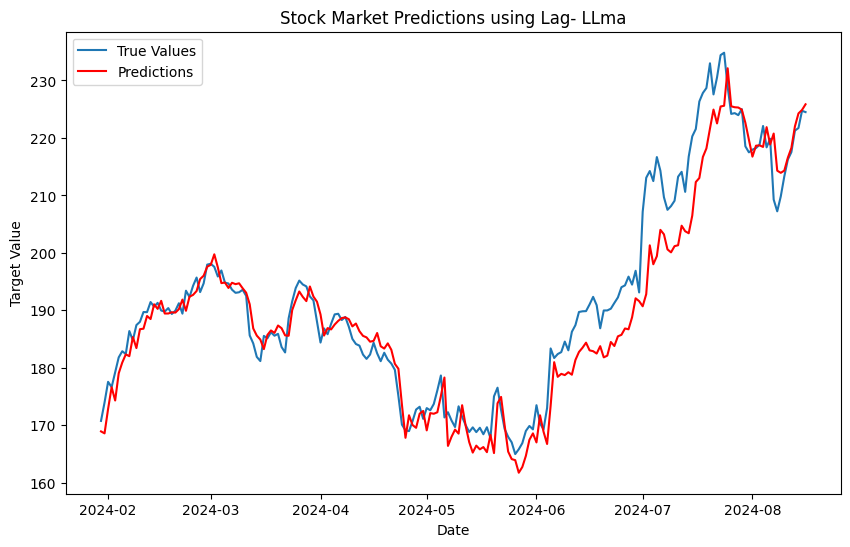

In [ ]:
modelEvaluater('Lag- LLma',ytest,ypred,xtest)